In [1]:
# Electricity Load Forecasting - Exploratory Data Analysis (EDA)

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "data/train_dataframes.xlsx"  # Change this to your file path
xls = pd.ExcelFile(file_path)

# Load a subset of sheets (first 5) for efficient analysis
selected_sheets = xls.sheet_names[:5]
df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in selected_sheets]
df = pd.concat(df_list, ignore_index=True)

# Convert datetime column to proper format
df["datetime"] = pd.to_datetime(df["datetime"])

# Display first few rows
df.head()


,datetime,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
0,2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
1,2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2,2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
3,2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
4,2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
file_path = "data/train_dataframes.xlsx"  # Change this path
xls = pd.ExcelFile(file_path)

# Load selected sheets (first 5 to optimize performance)
selected_sheets = xls.sheet_names[:5]
df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in selected_sheets]
df = pd.concat(df_list, ignore_index=True)

# Convert datetime column to datetime type
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace=True)

# Display basic info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191496 entries, 2015-01-31 01:00:00 to 2019-08-14 00:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   week_X-2    191496 non-null  float64
 1   week_X-3    191496 non-null  float64
 2   week_X-4    191496 non-null  float64
 3   MA_X-4      191496 non-null  float64
 4   dayOfWeek   191496 non-null  int64  
 5   weekend     191496 non-null  int64  
 6   holiday     191496 non-null  int64  
 7   Holiday_ID  191496 non-null  int64  
 8   hourOfDay   191496 non-null  int64  
 9   T2M_toc     191496 non-null  float64
 10  DEMAND      191496 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 17.5 MB


,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
datetime,,,,,,,,,,,
2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472


In [3]:
# Create lag features (important lags based on ACF/PACF)
for lag in [1, 7, 14, 21, 28]:
    df[f"lag_{lag}"] = df["DEMAND"].shift(lag)

# Create rolling statistics (3-day, 7-day, 14-day moving averages)
df["rolling_mean_3"] = df["DEMAND"].rolling(window=3, min_periods=1).mean()
df["rolling_mean_7"] = df["DEMAND"].rolling(window=7, min_periods=1).mean()
df["rolling_mean_14"] = df["DEMAND"].rolling(window=14, min_periods=1).mean()

# Optionally: create rolling std deviation (helps in volatile demand)
df["rolling_std_7"] = df["DEMAND"].rolling(window=7, min_periods=1).std()

# Time-based features
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)  # New feature

# Drop NaN values generated by lagging
df.dropna(inplace=True)

# Display updated data
df.head()


,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,...,lag_21,lag_28,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_std_7,hour,dayofweek,month,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,
2015-02-01 05:00:00,815.4005,842.7522,884.6659,834.463400,2,1,0,0,5,25.043604,...,1077.8575,954.2018,859.554733,899.297300,990.348871,49.740936,5,6,2,1
2015-02-01 06:00:00,785.2751,807.4211,862.9888,810.501925,2,1,0,0,6,25.096826,...,1179.6601,913.8660,842.977867,875.539257,971.814971,38.422319,6,6,2,1
2015-02-01 07:00:00,784.1150,813.1819,871.6873,815.810325,2,1,0,0,7,26.019800,...,1255.1569,903.3637,836.889000,861.114386,955.650414,27.911603,7,6,2,1
2015-02-01 08:00:00,850.1076,873.8010,912.4966,867.222075,2,1,0,0,8,27.205042,...,1253.4414,889.0806,853.417633,860.408843,941.640557,26.670768,8,6,2,1
2015-02-01 09:00:00,900.5203,935.3192,969.8017,925.125075,2,1,0,0,9,28.295648,...,1223.6116,910.1472,901.311667,872.123600,930.875036,48.117779,9,6,2,1


In [4]:
import pandas as pd

# Load your train and test datasets
train_df = df.copy()  # Assuming your feature-engineered training df is already named df
test_df = pd.read_excel("./data/test_dataframes.xlsx")

# Ensure datetime is correctly set
if "datetime" in test_df.columns:
    test_df["datetime"] = pd.to_datetime(test_df["datetime"])
    test_df.set_index("datetime", inplace=True)

# -------------------------
# Feature Engineering - Must be SAME for both train and test
# -------------------------

# Lags
for lag in [1, 7, 14, 21, 28]:
    train_df[f"lag_{lag}"] = train_df["DEMAND"].shift(lag)
    test_df[f"lag_{lag}"] = test_df["DEMAND"].shift(lag)

# Rolling means and std
for window in [3, 7, 14]:
    train_df[f"rolling_mean_{window}"] = train_df["DEMAND"].rolling(window=window).mean()
    test_df[f"rolling_mean_{window}"] = test_df["DEMAND"].rolling(window=window).mean()

train_df["rolling_std_7"] = train_df["DEMAND"].rolling(window=7).std()
test_df["rolling_std_7"] = test_df["DEMAND"].rolling(window=7).std()

# Time-based features
for df_ in [train_df, test_df]:
    df_["hour"] = df_.index.hour
    df_["dayofweek"] = df_.index.dayofweek
    df_["month"] = df_.index.month
    df_["is_weekend"] = df_.index.dayofweek.isin([5, 6]).astype(int)

# -------------------------
# Drop NaNs generated by rolling/lags
# -------------------------
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# -------------------------
# Create X_train, y_train, and X_test
# -------------------------
TARGET = "DEMAND"

features = [col for col in train_df.columns if col != TARGET]

X_train = train_df[features]
y_train = train_df[TARGET]

X_test = test_df[features]  # Same features as training
y_test = test_df['DEMAND']

# Confirm shape
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")



X_train shape: (191440, 23)
y_train shape: (191440,)
X_test shape: (140, 23)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best SVR Parameters: {'kernel': 'rbf', 'epsilon': 0.1, 'C': 10}
SVR MAE: 22.34, RMSE: 29.57


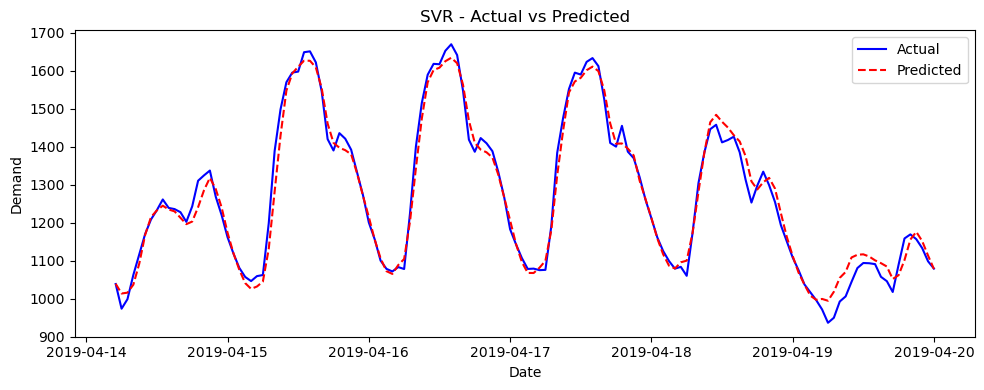

In [7]:
# Import necessary libraries for SVM and GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Align X_test and y_test
X_test, y_test = X_test.align(y_test, join='inner', axis=0)

param_grid = {
    'C': [1, 10],
    'epsilon': [0.1, 0.5],
    'kernel': ['rbf']
}

random_search = RandomizedSearchCV(
    SVR(), param_distributions=param_grid,
    n_iter=4, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=1, random_state=42
)
random_search.fit(X_train, y_train)

svr_best = random_search.best_estimator_
y_pred = svr_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best SVR Parameters:", random_search.best_params_)
print(f"SVR MAE: {mae:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red", linestyle="dashed")
plt.title("SVR - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.tight_layout()
plt.show()




In [9]:
# Libraries
import statsmodels.api as sm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# ================================
# Step 1: ARIMA
# ================================
print("Training ARIMA...")

# Fit ARIMA on y_train only
arima_model = sm.tsa.ARIMA(y_train, order=(2,1,1))
arima_result = arima_model.fit()

# Predict with ARIMA
arima_forecast = arima_result.forecast(steps=len(y_test))

# ================================
# Step 2: Prophet
# ================================
print("Training Prophet...")

# Prepare data for Prophet
prophet_train = y_train.reset_index()
prophet_train.columns = ['ds', 'y']

# Fit Prophet
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Prepare future dates for Prophet
future = y_test.reset_index()[['datetime']]
future.columns = ['ds']

# Predict with Prophet
prophet_forecast = prophet_model.predict(future)['yhat'].values

# ================================
# Step 3: LSTM with TensorFlow (your architecture)
# ================================
print("Training LSTM...")

# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

time_step = 60  # Number of previous steps
X_train_lstm, y_train_lstm = create_dataset(y_train_scaled, time_step)
X_test_lstm, y_test_lstm = create_dataset(y_test_scaled, time_step)

# Reshape input for LSTM
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

# Compile and train the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=2, batch_size=32)

# Make predictions
predicted_demand_lstm = model_lstm.predict(X_test_lstm)

# Inverse transform predictions and actual values
predicted_demand_lstm = scaler.inverse_transform(predicted_demand_lstm)
y_test_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))


Training ARIMA...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/

Training Prophet...


00:13:55 - cmdstanpy - INFO - Chain [1] start processing
00:14:52 - cmdstanpy - INFO - Chain [1] done processing


Training LSTM...


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
5981/5981 ━━━━━━━━━━━━━━━━━━━━ 275s 46ms/step - loss: 0.0084
Epoch 2/2
5981/5981 ━━━━━━━━━━━━━━━━━━━━ 141s 24ms/step - loss: 7.2521e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


In [10]:
# ================================
# Step 4: Ensemble Averaging
# ================================
print("Combining predictions...")

# Convert forecasts to numpy arrays
arima_forecast = np.array(arima_forecast)
prophet_forecast = np.array(prophet_forecast)
lstm_forecast = np.array(predicted_demand_lstm)

# FIX: Align ARIMA and Prophet forecasts to match LSTM output
arima_forecast = arima_forecast[time_step:]
prophet_forecast = prophet_forecast[time_step:]

# Average the forecasts
final_ensemble_forecast = (arima_forecast + prophet_forecast + lstm_forecast) / 3

# ================================
# Step 5: Evaluation
# ================================
mae = mean_absolute_error(y_test_actual, final_ensemble_forecast)
rmse = np.sqrt(mean_squared_error(y_test_actual, final_ensemble_forecast))

print(f"[Hybrid 4] ARIMA + Prophet + LSTM Ensemble -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")

# ================================
# Step 6: Plot
# ================================
plt.figure(figsize=(12,6))
plt.plot(y_test.index[time_step:], y_test_actual, label='Actual')
plt.plot(y_test.index[time_step:], final_ensemble_forecast, label='Ensemble Prediction', linestyle='--')
plt.legend()
plt.title('Hybrid 4: ARIMA + Prophet + LSTM Ensemble Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.show()

Combining predictions...


ValueError: y_true and y_pred have different number of output (1!=80)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

time_step = 60  # Number of previous time steps to use for prediction
X_train_lstm, y_train_lstm = create_dataset(y_train_scaled, time_step)
X_test_lstm, y_test_lstm = create_dataset(y_test_scaled, time_step)

# Reshape data for LSTM input
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

# Compile and fit the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=2, batch_size=32)

# Make predictions with LSTM
predicted_demand_lstm = model_lstm.predict(X_test_lstm)

# Inverse transform predictions and actual values
predicted_demand_lstm = scaler.inverse_transform(predicted_demand_lstm)
y_test_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Step 2: Residuals (y_test - LSTM predictions)
residuals = y_test_actual - predicted_demand_lstm



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
5981/5981 ━━━━━━━━━━━━━━━━━━━━ 108s 18ms/step - loss: 0.0095
Epoch 2/2
5981/5981 ━━━━━━━━━━━━━━━━━━━━ 106s 18ms/step - loss: 7.5082e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [ ]:
# Make predictions with LSTM
predicted_demand_lstm = model_lstm.predict(X_test_lstm)

# Inverse transform predictions and actual values
predicted_demand_lstm = scaler.inverse_transform(predicted_demand_lstm)
y_test_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# ================================
# Step 4: Ensemble Averaging
# ================================
print("Combining predictions...")

# Ensure all forecasts are numpy arrays
arima_forecast = np.array(arima_forecast)
prophet_forecast = np.array(prophet_forecast)
lstm_forecast = np.array(predicted_demand_lstm)

# Average the forecasts
final_ensemble_forecast = (arima_forecast + prophet_forecast + lstm_forecast) / 3

# ================================
# Step 5: Evaluation
# ================================
mae = mean_absolute_error(y_test_actual, final_ensemble_forecast)
rmse = np.sqrt(mean_squared_error(y_test_actual, final_ensemble_forecast))

print(f"[Hybrid 4] ARIMA + Prophet + LSTM Ensemble -> MAE: {mae:.2f} | RMSE: {rmse:.2f}")

# ================================
# Step 6: Plot
# ================================
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test_actual, label='Actual')
plt.plot(y_test.index, final_ensemble_forecast, label='Ensemble Prediction', linestyle='--')
plt.legend()
plt.title('Hybrid 4: ARIMA + Prophet + LSTM Ensemble Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Calculate the residuals from the LSTM model predictions
lstm_predictions = model_lstm.predict(X_train_lstm)
residuals = y_train_lstm - lstm_predictions

# Define the hyperparameters for XGBoost
param_grid_xgb = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Perform Grid Search CV to tune the model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, residuals)  # Fit grid search on residuals

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
xgb_predictions = best_model.predict(X_test)

# Add the predicted residuals back to the LSTM predictions to get the final prediction
final_predictions = lstm_predictions + xgb_predictions

# Inverse transform to get the actual values
final_predictions = scaler.inverse_transform(final_predictions)

# Evaluate the model (MAE, RMSE)
mae_final = mean_absolute_error(y_test_actual, final_predictions)
rmse_final = np.sqrt(mean_squared_error(y_test_actual, final_predictions))

print(f"Final Model - Mean Absolute Error (MAE): {mae_final:.2f}")
print(f"Final Model - Root Mean Squared Error (RMSE): {rmse_final:.2f}")


# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test_actual, label="Actual Demand", color="blue")
plt.plot(y_test.index, final_predictions, label="Hybrid Prediction (LSTM+XGB)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Electricity Demand")
plt.title("LSTM + XGBoost (Hybrid Model) - Actual vs Predicted Demand")
plt.legend()
plt.show()


5981/5981 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step


: 